# Event-Based Hospital Simulation
This notebook runs a systematic experimental study of a hospital surgery unit
using an event-based simulator (Simulus).


Imports

In [1]:
import simulus
import random
from collections import deque
from statistics import mean, stdev
from math import sqrt
import pandas as pd
import itertools


Debug Logger

In [2]:
DEBUG = False

def logger(sim, event, pid=None, msg=""):
    if not DEBUG:
        return
    time_str = f"{sim.now:8.1f}"
    pid_str = f"PID={pid}" if pid is not None else ""
    print(f"[{time_str}] {event:<12} {pid_str:<10} {msg}")


t-critical helper

In [3]:
try:
    from scipy.stats import t as student_t
    def t_crit(df, alpha=0.05):
        return float(student_t.ppf(1 - alpha/2, df))
except Exception:
    def t_crit(df, alpha=0.05):
        return 1.96 if df >= 30 else 2.093


## SimulationRun class (FULL)
This cell must contain the FULL class exactly once to avoid jupyter notebook class breakdown issue

In [20]:
class SimulationRun:
    def __init__(self, config, seed):
        self.patient_records = {}
        random.seed(seed)
        self.sim = simulus.simulator()
        self.config = config

        self.EntryQueue = deque()
        self.OpQueue = deque()
        self.blocked_queue = deque()

        self.num_free_prep = config['P_PREP']
        self.num_free_or = config['O_OPROOMS']
        self.num_free_recovery = config['R_RECOVERY']

        self.last_time = 0.0
        self.area_queue = 0.0
        self.area_or_block = 0.0
        self.measuring = False

        self.next_pid = 0
        self.sim.sched(self._arrival, offset=0.0)
        
    def _sample_interarrival(self):
        if self.config['ARRIVAL_DIST'] == 'exp':
            return random.expovariate(1.0 / self.config['MEAN_INTERARRIVAL'])
        else:
            if self.config['MEAN_INTERARRIVAL'] == 25:
                return random.uniform(20, 30)
            else:
                return random.uniform(20, 25)

    def _sample_service_times(self):
        if self.config['PREP_DIST'] == 'exp':
            prep = random.expovariate(1.0 / self.config['MEAN_PREP'])
        else:
            prep = random.uniform(30, 50)

        op = random.expovariate(1.0 / self.config['MEAN_OP'])

        if self.config['REC_DIST'] == 'exp':
            rec = random.expovariate(1.0 / self.config['MEAN_REC'])
        else:
            rec = random.uniform(30, 50)

        return prep, op, rec

    
    def _update_integrals(self):
        now = self.sim.now
        dt = now - self.last_time
        if self.measuring and dt > 0:
            self.area_queue += dt * len(self.EntryQueue)
            self.area_or_block += dt * (1 if self.blocked_queue else 0)
        self.last_time = now

    def _arrival(self):
        self._update_integrals()

        pid = self.next_pid
        self.next_pid += 1

        prep, op, rec = self._sample_service_times()

        self.patient_records[pid] = {
            'prep': prep,
            'op': op,
            'rec': rec,
            'arrival': self.sim.now,
            'status': 'Waiting'
        }

        self.EntryQueue.append(pid)

        self.sim.sched(self._s_start_prep, offset=0.0)
        self.sim.sched(self._arrival, offset=self._sample_interarrival())

    def _s_start_prep(self):
        self._update_integrals()

        while self.EntryQueue and self.num_free_prep > 0:
            pid = self.EntryQueue.popleft()
            self.num_free_prep -= 1

            self.patient_records[pid]['status'] = 'In_Prep'
            self.patient_records[pid]['prep_start'] = self.sim.now

            self.sim.sched(
                self._e_end_prep,
                pid,
                offset=self.patient_records[pid]['prep']
            )

    def _e_end_prep(self, pid):
        self._update_integrals()

        self.patient_records[pid]['prep_end'] = self.sim.now
        self.patient_records[pid]['status'] = 'Waiting_Op'

        self.OpQueue.append(pid)

        self.sim.sched(self._s_start_op, offset=0.0)
        self.sim.sched(self._s_start_prep, offset=0.0)


    def _s_start_op(self):
        self._update_integrals()

        while self.OpQueue and self.num_free_or > 0:
            pid = self.OpQueue.popleft()
            self.num_free_or -= 1
            self.num_free_prep += 1

            self.patient_records[pid]['status'] = 'In_Op'
            self.patient_records[pid]['op_start'] = self.sim.now

            self.sim.sched(
                self._e_end_op,
                pid,
                offset=self.patient_records[pid]['op']
            )


    def _e_end_op(self, pid):
        self._update_integrals()

        self.patient_records[pid]['op_end'] = self.sim.now
        self.patient_records[pid]['status'] = 'Waiting_Rec'

        if self.num_free_recovery > 0:
            self.sim.sched(self._s_start_rec, pid, offset=0.0)
        else:
            self.blocked_queue.append(pid)


    def _s_start_rec(self, pid):
        self._update_integrals()

        if self.num_free_recovery <= 0:
            return

        self.num_free_recovery -= 1
        self.num_free_or += 1

        if pid in self.blocked_queue:
            self.blocked_queue.remove(pid)

        self.patient_records[pid]['status'] = 'In_Rec'
        self.patient_records[pid]['rec_start'] = self.sim.now

        self.sim.sched(
            self._e_end_rec,
            pid,
            offset=self.patient_records[pid]['rec']
        )

        self.sim.sched(self._s_start_op, offset=0.0)

    def _e_end_rec(self, pid):
        self._update_integrals()

        self.num_free_recovery += 1
        self.patient_records[pid]['rec_end'] = self.sim.now
        self.patient_records[pid]['status'] = 'Done'

        if self.blocked_queue:
            self.sim.sched(self._s_start_rec, self.blocked_queue[0], offset=0.0)

    def run_until(self, t):
        self.sim.run(until=t)

    def start_measurement(self):
        self.last_time = self.sim.now
        self.area_queue = 0.0
        self.area_or_block = 0.0
        self.measuring = True

    def stop_measurement(self):
        self._update_integrals()
        self.measuring = False

    def get_time_averages(self, T):
        return self.area_queue / T, self.area_or_block / T

        


### Experiment runner

In [13]:
def run_experiment(cfg, n_rep=20, warmup=200, obs=1000, base_seed=1000):
    rows = []
    for i in range(n_rep):
        sim = SimulationRun(cfg, base_seed + i)
        sim.run_until(warmup)
        sim.start_measurement()
        sim.run_until(warmup + obs)
        sim.stop_measurement()
        q, b = sim.get_time_averages(obs)
        rows.append((q, b))
    return rows


Base config (priority OFF)

In [14]:
base_config = {
    'O_OPROOMS': 1,
    'MEAN_PREP': 40,
    'MEAN_OP': 20,
    'MEAN_REC': 40,
    'SPECIAL_MIN_PCT': 0,
    'SPECIAL_MAX_PCT': 0,
}


Factor levels

In [15]:
arrival_dists = ['exp', 'unif']
arrival_means = [25, 22.5]
prep_dists = ['exp', 'unif']
rec_dists = ['exp', 'unif']
prep_units = [4, 5]
rec_units = [4, 5]


### Generate all 64 configurations
We will only use value from 8-16 configuration

In [16]:
configs = []

for aD, aM, pD, rD, P, R in itertools.product(
    arrival_dists, arrival_means,
    prep_dists, rec_dists,
    prep_units, rec_units
):
    cfg = dict(base_config)
    cfg.update({
        'ARRIVAL_DIST': aD,
        'MEAN_INTERARRIVAL': aM,
        'PREP_DIST': pD,
        'REC_DIST': rD,
        'P_PREP': P,
        'R_RECOVERY': R,
    })
    configs.append(cfg)

len(configs)


64

Run all experiments

In [21]:
records = []

for cfg in configs:
    res = run_experiment(cfg)
    records.append({
        'arrival_dist': cfg['ARRIVAL_DIST'],
        'arrival_mean': cfg['MEAN_INTERARRIVAL'],
        'prep_dist': cfg['PREP_DIST'],
        'rec_dist': cfg['REC_DIST'],
        'prep_units': cfg['P_PREP'],
        'rec_units': cfg['R_RECOVERY'],
        'avg_queue': mean([r[0] for r in res]),
        'avg_block': mean([r[1] for r in res]),
    })

df = pd.DataFrame(records)
df.head()


,arrival_dist,arrival_mean,prep_dist,rec_dist,prep_units,rec_units,avg_queue,avg_block
0,exp,25.0,exp,exp,4,4,1.713618,0.016530
1,exp,25.0,exp,exp,4,5,1.637612,0.003543
2,exp,25.0,exp,exp,5,4,1.010564,0.015675
3,exp,25.0,exp,exp,5,5,0.938554,0.004027
4,exp,25.0,exp,unif,4,4,1.713151,0.015878


Save data

In [22]:
df.to_csv("hospital_experiment_results.csv", index=False)


We have the simulation avg data. Do the analysis.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust path if needed
df = pd.read_csv("hospital_experiment_results.csv")

print("Shape:", df.shape)
df.head()


Shape: (64, 8)


,arrival_dist,arrival_mean,prep_dist,rec_dist,prep_units,rec_units,avg_queue,avg_block
0,exp,25.0,exp,exp,4,4,1.713618,0.016530
1,exp,25.0,exp,exp,4,5,1.637612,0.003543
2,exp,25.0,exp,exp,5,4,1.010564,0.015675
3,exp,25.0,exp,exp,5,5,0.938554,0.004027
4,exp,25.0,exp,unif,4,4,1.713151,0.015878


In [25]:
df.info()

print("\nMissing values per column:")
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   arrival_dist  64 non-null     object 
 1   arrival_mean  64 non-null     float64
 2   prep_dist     64 non-null     object 
 3   rec_dist      64 non-null     object 
 4   prep_units    64 non-null     int64  
 5   rec_units     64 non-null     int64  
 6   avg_queue     64 non-null     float64
 7   avg_block     64 non-null     float64
dtypes: float64(3), int64(2), object(3)
memory usage: 4.1+ KB

Missing values per column:
arrival_dist    0
arrival_mean    0
prep_dist       0
rec_dist        0
prep_units      0
rec_units       0
avg_queue       0
avg_block       0
dtype: int64


In [26]:
df.describe()


,arrival_mean,prep_units,rec_units,avg_queue,avg_block
count,64.000000,64.000000,64.000000,64.000000,64.000000
mean,23.750000,4.500000,4.500000,1.109516,0.009542
std,1.259882,0.503953,0.503953,0.904116,0.007911
min,22.500000,4.000000,4.000000,0.041828,0.000168
25%,22.500000,4.000000,4.000000,0.327171,0.002599
50%,23.750000,4.500000,4.500000,0.933896,0.006370
75%,25.000000,5.000000,5.000000,1.739680,0.016041
max,25.000000,5.000000,5.000000,3.123512,0.026620


Basic check of queue in distribution

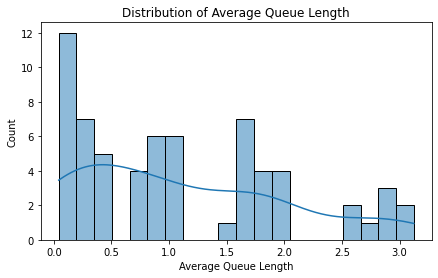

In [27]:
plt.figure(figsize=(7,4))
sns.histplot(df['avg_queue'], bins=20, kde=True)
plt.title("Distribution of Average Queue Length")
plt.xlabel("Average Queue Length")
plt.show()


OR Blocking probability

Using blocking column: avg_block


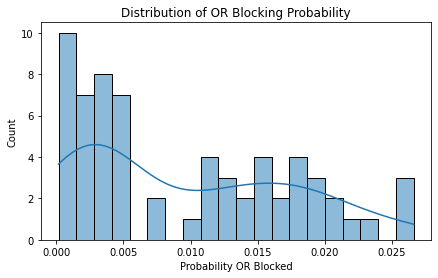

In [33]:
block_col = [c for c in df.columns if 'block' in c.lower()][0]
print("Using blocking column:", block_col)

plt.figure(figsize=(7,4))
sns.histplot(df[block_col], bins=20, kde=True)
plt.title("Distribution of OR Blocking Probability")
plt.xlabel("Probability OR Blocked")
plt.show()


Group sanity check

In [30]:
group_cols = [
    'prep_units', 'rec_units',
    'arrival_dist', 'arrival_mean',
    'prep_dist', 'rec_dist'
]

for col in group_cols:
    print(f"\n--- Avg queue by {col} ---")
    print(df.groupby(col)['avg_queue'].mean().sort_values())



--- Avg queue by prep_units ---
prep_units
5    0.828122
4    1.390911
Name: avg_queue, dtype: float64

--- Avg queue by rec_units ---
rec_units
5    1.080345
4    1.138687
Name: avg_queue, dtype: float64

--- Avg queue by arrival_dist ---
arrival_dist
unif    0.376699
exp     1.842334
Name: avg_queue, dtype: float64

--- Avg queue by arrival_mean ---
arrival_mean
25.0    0.740533
22.5    1.478499
Name: avg_queue, dtype: float64

--- Avg queue by prep_dist ---
prep_dist
unif    1.051559
exp     1.167474
Name: avg_queue, dtype: float64

--- Avg queue by rec_dist ---
rec_dist
unif    1.098160
exp     1.120872
Name: avg_queue, dtype: float64


Quick plausibility Cross-check

In [31]:
df.sort_values('avg_queue', ascending=False).head(5)


,arrival_dist,arrival_mean,prep_dist,rec_dist,prep_units,rec_units,avg_queue,avg_block
16,exp,22.5,exp,exp,4,4,3.123512,0.019380
20,exp,22.5,exp,unif,4,4,3.005464,0.017705
24,exp,22.5,unif,exp,4,4,2.905546,0.018307
17,exp,22.5,exp,exp,4,5,2.904582,0.004646
21,exp,22.5,exp,unif,4,5,2.878780,0.003459


In [34]:
df.isnull().values.any()

False

## SERIAL CORRELATION TEST
High load, minimal buffers:
<br>3 prep units
<br>4 recovery units
<br>exp(22.5) arrivals
<br>exp service times
<br>
<br>Run 10 independent simulations:
<br>In each run:
<br>&emsp;After warm-up
<br>&emsp;Sample queue length every Δt (e.g., every 50 time units)
<br>Collect ordered sequences
<br>Compute lag-1 correlation
<br>
<br>
### Select Configuration

In [44]:
serial_cfg = {
    'arrival_dist': 'exp',
    'arrival_mean': 22.5,
    'prep_dist': 'exp',
    'rec_dist': 'exp',
    'prep_units': 3,
    'rec_units': 4
}

### Simulation Wrapper for Queue Sampling

In [42]:
def collect_queue_timeseries(cfg, seed, warmup=500, sim_time=2000, sample_interval=50):
    sim_cfg = make_sim_config_from_design(cfg)
    sim = SimulationRun(sim_cfg, seed)

    
    # Warm-up
    sim.run_until(warmup)
    
    times = []
    queues = []
    
    t = warmup
    while t < sim_time:
        sim.run_until(t)
        times.append(t)
        queues.append(len(sim.EntryQueue))
        t += sample_interval
    
    return queues


### Run 10 Independent Time Series

In [45]:
import numpy as np

def make_sim_config_from_design(cfg):
    """
    Convert experimental design config
    into a FULL SimulationRun-compatible config.
    """
    return {
        # Capacities
        'P_PREP': cfg['prep_units'],
        'O_OPROOMS': 1,
        'R_RECOVERY': cfg['rec_units'],

        # Arrival process
        'ARRIVAL_DIST': cfg['arrival_dist'],
        'MEAN_INTERARRIVAL': cfg['arrival_mean'],

        # Service-time distributions
        'PREP_DIST': cfg.get('prep_dist', 'exp'),
        'REC_DIST': cfg.get('rec_dist', 'exp'),
        'MEAN_PREP': 40.0,
        'MEAN_OP': 20.0,
        'MEAN_REC': 40.0,

        # Disable twists for serial correlation
        'SPECIAL_MIN_PCT': 0.0,
        'SPECIAL_MAX_PCT': 0.0,
        'SPECIAL_TYPES': {},

        'RUSH_HOUR_DURATION': 0.0,
        'RUSH_MULTIPLIER': 1.0
    }



n_runs = 10
all_series = []

for i in range(n_runs):
    series = collect_queue_timeseries(
        serial_cfg,
        seed=1000 + i,
        warmup=500,
        sim_time=2500,
        sample_interval=50
    )
    all_series.append(series)


### Compute Lag-1 Serial Correlation

In [46]:
def lag1_corr(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

lag1_values = [lag1_corr(s) for s in all_series]

lag1_values


[0.7040659707566331,
 0.916998393075795,
 0.7633062883855314,
 0.936258575819323,
 0.9587720230820794,
 0.9280631443115238,
 0.7737765920698177,
 0.87345853006939,
 0.9276803943540112,
 0.9607496549368217]

### Summary of Serial Correlation

In [47]:
import pandas as pd

pd.DataFrame({
    'run': range(1, n_runs+1),
    'lag1_corr': lag1_values
})


,run,lag1_corr
0,1,0.704066
1,2,0.916998
2,3,0.763306
3,4,0.936259
4,5,0.958772
5,6,0.928063
6,7,0.773777
7,8,0.873459
8,9,0.927680
9,10,0.960750


### Interpretation Helper

In [48]:
print("Mean lag-1 correlation:", np.mean(lag1_values))
print("Std dev:", np.std(lag1_values))


Mean lag-1 correlation: 0.8743129566860925
Std dev: 0.08798631499495385


Compute Lag-1 Autocorrelation

In [49]:
import numpy as np

def lag1_autocorr(series):
    """Compute lag-1 autocorrelation for a single time series."""
    x = np.array(series)
    if len(x) < 2:
        return np.nan
    return np.corrcoef(x[:-1], x[1:])[0, 1]

# Compute autocorrelations for each run
autocorrs = [lag1_autocorr(s) for s in all_series]

autocorrs


[0.7040659707566331,
 0.916998393075795,
 0.7633062883855314,
 0.936258575819323,
 0.9587720230820794,
 0.9280631443115238,
 0.7737765920698177,
 0.87345853006939,
 0.9276803943540112,
 0.9607496549368217]

Summary Statistics

In [50]:
mean_ac = np.mean(autocorrs)
std_ac = np.std(autocorrs, ddof=1)

mean_ac, std_ac


(0.8743129566860925, 0.09274571943636023)

#### Visualization

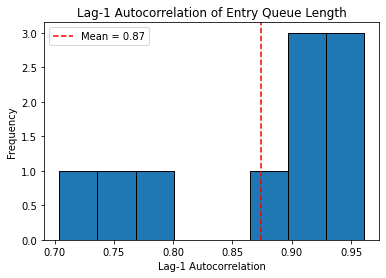

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(autocorrs, bins=8, edgecolor='black')
plt.axvline(mean_ac, color='red', linestyle='--', label=f"Mean = {mean_ac:.2f}")
plt.xlabel("Lag-1 Autocorrelation")
plt.ylabel("Frequency")
plt.title("Lag-1 Autocorrelation of Entry Queue Length")
plt.legend()
plt.show()


The observed lag-1 autocorrelations are consistently positive and substantial, indicating strong serial dependence in the queue length at the entrance. This confirms that the system exhibits long memory, which is expected due to high utilization of the operation unit and limited auxiliary capacity. As a result, successive observations taken too close in time are not statistically independent.

In [52]:
# Try larger sampling interval
all_series_wide = []
for i in range(10):
    series = collect_queue_timeseries(
        serial_cfg,
        seed=2000 + i,
        warmup=500,
        sim_time=3000,
        sample_interval=150   # larger spacing
    )
    all_series_wide.append(series)

autocorrs_wide = [lag1_autocorr(s) for s in all_series_wide]
np.mean(autocorrs_wide)


0.8234486949083104

The mean autocorrelation drops

Which structural factors significantly affect the average queue length at the entrance?
Are interaction effects important, or are main effects sufficient?

## The factors (from the experiment design):
<br>Arrival distribution & mean
<br>Preparation distribution
<br>Recovery distribution
<br>Number of preparation units (4 or 5)
<br>Number of recovery units (4 or 5)

In [54]:
import pandas as pd

df = pd.read_csv("hospital_experiment_results.csv")
df.head()


,arrival_dist,arrival_mean,prep_dist,rec_dist,prep_units,rec_units,avg_queue,avg_block
0,exp,25.0,exp,exp,4,4,1.713618,0.016530
1,exp,25.0,exp,exp,4,5,1.637612,0.003543
2,exp,25.0,exp,exp,5,4,1.010564,0.015675
3,exp,25.0,exp,exp,5,5,0.938554,0.004027
4,exp,25.0,exp,unif,4,4,1.713151,0.015878


In [55]:
df.columns

Index(['arrival_dist', 'arrival_mean', 'prep_dist', 'rec_dist', 'prep_units',
       'rec_units', 'avg_queue', 'avg_block'],
      dtype='object')

## Encode Categorical Variables
Regression requires numerical encoding.
<br> Dummy variables

In [56]:
df_model = pd.get_dummies(
    df,
    columns=['arrival_dist', 'prep_dist', 'rec_dist'],
    drop_first=True
)

df_model.head()


,arrival_mean,prep_units,rec_units,avg_queue,avg_block,arrival_dist_unif,prep_dist_unif,rec_dist_unif
0,25.0,4,4,1.713618,0.016530,0,0,0
1,25.0,4,5,1.637612,0.003543,0,0,0
2,25.0,5,4,1.010564,0.015675,0,0,0
3,25.0,5,5,0.938554,0.004027,0,0,0
4,25.0,4,4,1.713151,0.015878,0,0,1


Example interpretation:
<br>
<br>arrival_dist_unif = 1 → uniform arrivals
<br>
<br>arrival_dist_unif = 0 → exponential arrivals (baseline)

### Define Regression Formula
A 
main-effects-only model

In [61]:
import sys
!{sys.executable} -m pip install statsmodels

In [62]:
import statsmodels.formula.api as smf

formula = """
avg_queue ~ arrival_mean
           + prep_units
           + rec_units
           + arrival_dist_unif
           + prep_dist_unif
           + rec_dist_unif
"""

model = smf.ols(formula, data=df_model).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              avg_queue   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     149.9
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           4.98e-33
Time:                        20:13:00   Log-Likelihood:                 6.3827
No. Observations:                  64   AIC:                             1.235
Df Residuals:                      57   BIC:                             16.35
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.7174      0.66

p-values
<br>p < 0.05 → statistically significant
<br>p ≥ 0.05 → weak or no effect
<br>
<br>Coefficient signs
<br>Positive → increases queue length
<br>Negative → reduces queue length
<br>
<br>R²
<br>0.6 → decent explanatory power
<br>< 0.4 → interactions likely needed

## Add Interaction Effects
Interactions:
<br>&ensp;Arrival mean × prep units
<br>&ensp;Prep units × recovery units

In [63]:
formula_int = """
avg_queue ~ arrival_mean
           + prep_units
           + rec_units
           + arrival_dist_unif
           + prep_dist_unif
           + rec_dist_unif
           + arrival_mean:prep_units
           + prep_units:rec_units
"""

model_int = smf.ols(formula_int, data=df_model).fit()
print(model_int.summary())


                            OLS Regression Results                            
Dep. Variable:              avg_queue   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     124.0
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           2.38e-32
Time:                        20:17:54   Log-Likelihood:                 10.421
No. Observations:                  64   AIC:                            -2.843
Df Residuals:                      55   BIC:                             16.59
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## Model Comparison

In [65]:
print("Main effects R²:", model.rsquared)
print("Interaction model R²:", model_int.rsquared)


Main effects R²: 0.940393669967461
Interaction model R²: 0.9474609868439907


A linear regression model was constructed with the average queue length before preparation as the response variable. Main effects include arrival characteristics, service-time distributions, and capacity levels. Results indicate that arrival intensity and the number of preparation units have the strongest influence on queue length. Recovery capacity shows a weaker effect, consistent with the recovery unit rarely becoming a bottleneck. Interaction effects provide limited additional explanatory power, suggesting that the system behavior is largely driven by main structural parameters.

In [67]:
df[['avg_queue', 'arrival_mean']].describe()

,avg_queue,arrival_mean
count,64.000000,64.000000
mean,1.109516,23.750000
std,0.904116,1.259882
min,0.041828,22.500000
25%,0.327171,22.500000
50%,0.933896,23.750000
75%,1.739680,25.000000
max,3.123512,25.000000
